## Import Libraries

In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import random
from random import randint
import os
import glob
import cv2
import pickle
from zipfile import ZipFile
import imageio
import time
import statistics
import editdistance
import traceback
import cProfile
import LM.clean
import LM.segment

%matplotlib inline
figure_size = 15
plt.rcParams['figure.figsize'] = (figure_size, figure_size)
plt.rcParams['image.interpolation'] = 'nearest'

from SegLink import datasets
from SegLink.ssd_utils import load_weights
from SegLink.ssd_data import InputGenerator, preprocess
from SegLink.sl_model import SL512, SL512v2
from SegLink.sl_utils import PriorUtil, rbox_to_polygon, polygon_to_rbox
from SegLink.sl_metric import evaluate_results, fscore
from SegLink.ssd_viz import plot_box, escape_latex
from SegLink.ssd_training import Logger

import keras
import keras.backend as K
from keras.backend.tensorflow_backend import set_session
from keras.callbacks import Callback
from keras.optimizers import SGD, Adam
import tensorflow as tf

from CRNN.crnn_model import CRNN, CRNNv2
from CRNN.crnn_data import InputGenerator, crop_words 
from CRNN.crnn_utils import alphabet87 as alphabet
from CRNN.crnn_utils import decode

Using TensorFlow backend.


## Import Datasets

In [2]:
# from data_icdar2015ist import GTUtility
# gt_util_test_2015 = GTUtility('data/ICDAR2015_IST/', test=True)

# from data_icdar2015fst import GTUtility
# gt_util_test_2013 = GTUtility('data/ICDAR2015_FST/', test=True, polygon=True)

# print(gt_util_test_2013)
# print(gt_util_test_2015)

random.seed(1337)
from data_synthtext import GTUtility
with open('gt_util_synthtext_seglink.pkl', 'rb') as f:
    gt_util = pickle.load(f)
# gt_util_train, gt_util_other = gt_util.split(gt_util, split=0.5)
# gt_util_val, foo = gt_util.split(gt_util_other, split=0.03)
# gt_util_test, bar = gt_util.split(foo, split=0.03)

gt_util_train, gt_util_val = gt_util.split(gt_util, split=0.95)
print(gt_util)
gt_util_synth, foo = gt_util.split(gt_util, split=0.005)
print(gt_util_synth)

# print(gt_util_train)
# print(gt_util_val)
# print(gt_util_test)

# testing_icdar2013_recognition_images, testing_icdar2013_recognition_image_names, testing_icdar2015_recognition_images, testing_icdar2015_recognition_image_names = datasets.load_testing_real_recognition_datasets()

Background              0
Text              7266338

images             858749
objects           7266338
per image            8.46
no annotation           0

Background              0
Text                42095

images               4294
objects             42095
per image            9.80
no annotation           0



##### loading other datasets ...

In [3]:
# gts = glob.glob("./data/icdar_2013_focused_scene_text/localization/testing/gt/*.txt")
# # for g in gts:
# textfile = open(gts[0], 'r')
# textfile_data = textfile.readlines()
# textfile.close()
# gt = []
# for l in range(len(textfile_data)):
#     gt.append(textfile_data[l].split(",")[-1].rstrip().strip()[1:-1].lower())
# print(gt)

In [4]:
# gts = glob.glob("./data/icdar_2015_incidental_scene_text/localization/testing/gt/*.txt")
# gt = []
# for g in gts:
#     print(g)
#     textfile = open(g, 'r')
#     textfile_data = textfile.readlines()
#     textfile.close()
#     image_gt = []
#     for l in range(len(textfile_data)):
#         line = textfile_data[l].split(",")
#         word = line[-1].rstrip().lower()
#         if word == "###":
#             continue
#         else:
#             image_gt.append(line)
#     gt.append(image_gt)

In [5]:
# gt_util_test_2013.image_names[0].split(".")[0]

## Initialize Models

##### SegLink

In [6]:
model = SL512()
# model = SL512v2()
prior_util = PriorUtil(model)
image_size = model.image_size
# synth
# weights_path = './cps/sl/original_sl_synth/weights.001.h5'
weights_path = './SegLink/checkpoints/original_sl_synth/weights.001.h5'
# weights_path = './SegLink/checkpoints/weights.011.h5'
# weights_path = './checkpointsw/PRETRAINED WEIGHTS/SegLink/201809231008_sl512_synthtext/weights.002.h5'
# 2013
# weights_path = './cps/sl/original_sl_2013/weights.1150.h5'
# weights_path = './cps/sl/original_sl_2013/weights.998.h5'
# 2015
# weights_path = './cps/sl/original_sl_2015/weights.006.h5'
load_weights(model, weights_path)
checkdir = os.path.split(weights_path)[0]
# model.summary()

Instructions for updating:
dim is deprecated, use axis instead


##### CRNN

In [7]:
input_width = 256 
input_height = 32
# crnn_model = CRNN((input_width, input_height, 1), len(alphabet), prediction_only=True, gru=False)
# load_weights(crnn_model, './cps/crnn/original_crnn_synth/weights.400000.h5')
crnn_model = CRNNv2((input_width, input_height, 1), len(alphabet), prediction_only=True, gru=False)
load_weights(crnn_model, './CRNN/checkpoints/our_crnn_synth/weights.080000.h5')
# crnn_model.summary()

layer missing label_input
layer missing input_length
layer missing label_length
layer missing ctc


## Make Predictions

#### SegLink

In [8]:
inputs = []
images = []
images_orig = []
data = []

# gtu = gt_util_test_2013
# gtu = gt_util_test_2015
gtu = gt_util_synth
# average = 0
# np.random.seed(1337)
# countr = 0
# start = time.time()
# for i in range(0, gtu.num_samples, 16):
#     countr+=1
#     img = cv2.imread(os.path.join(gtu.image_path, gtu.image_names[i]))
#     preds = model.predict(np.asarray([preprocess(img, image_size)]), batch_size=1, verbose=1)
#     h, w = image_size
#     img = cv2.resize(img, (w,h), cv2.INTER_LINEAR).astype('float32')
#     img = img[:, :, (2,1,0)]
#     img /= 255
#     images.append(img)
#     gt_boxes = gtu.data[i]
#     boxes = gtu.data[i]
#     data.append(boxes)
# end = time.time()    

np.random.seed(1337)
countr = 0
start = time.time()
# for i in range(0, gtu.num_samples, 16):
for i in range(0, 16):
    countr+=1
    img = cv2.imread(os.path.join(gtu.image_path, gtu.image_names[i]))
    images_orig.append(np.copy(img))
    inputs.append(preprocess(img, image_size))
    h, w = image_size
    img = cv2.resize(img, (w,h), cv2.INTER_LINEAR).astype('float32')
    img = img[:, :, (2,1,0)]
    img /= 255
    images.append(img)
    boxes = gtu.data[i]
    data.append(boxes)

inputs = np.asarray(inputs)
preds = model.predict(inputs, batch_size=1, verbose=1)
end = time.time()

print("Detection took", end-start, "seconds")
print("For", countr, "frames")

16/16 [==============================] - 40s 3s/step
Detection took 40.352845907211304 seconds
For 16 frames


#### 2015

In [9]:
# for k in range(len(preds)):
#     res = prior_util.decode(preds[k], segment_threshold=0.75, link_threshold=0.6)

#     img_name = "./icdar2015res/res_" + gtu.image_names[k].split(".")[0] + ".txt"
#     print(img_name)
    
#     rboxes = res[:,:5]
#     if len(rboxes) == 0:
#         continue

#     boxes = np.asarray([rbox_to_polygon(r) for r in rboxes])
#     boxes = np.flip(boxes, axis=1)
#     boxes = np.reshape(boxes, (-1, 8))

#     boxes_mask_a = np.array([b[2] > b[3] for b in rboxes]) # width > height, in square world
#     boxes_mask_b = np.array([not (np.any(b < 0) or np.any(b > 512)) for b in boxes]) # box inside image
#     boxes_mask = np.logical_and(boxes_mask_a, boxes_mask_b)

#     boxes = boxes[boxes_mask]
#     rboxes = rboxes[boxes_mask]
#     if len(boxes) == 0:
#         boxes = np.empty((0,8))
#     with open(img_name, "w") as text_file:
#         write_string = ""
#         for box in boxes:
#             write_string = ','.join(str(int(e)) for e in box) + "\n"
#         text_file.write(write_string)

#### SegLink GridSearch

In [10]:
# from SegLink.sl_metric import evaluate_results, fscore

# def detection_results(preds, data):
#     steps_seg = np.arange(0.1, 1, 0.1)
#     steps_lnk = np.arange(0.1, 1, 0.1)

#     ordered = []
#     for i, segment_threshold in enumerate(steps_seg):
#         for j, link_threshold in enumerate(steps_lnk):
#             results = [prior_util.decode(p, segment_threshold=segment_threshold, link_threshold=link_threshold) for p in preds]
#             TP, FP, FN = evaluate_results(data, results)
#             recall = TP / (TP+FN)
#             precision = TP / (TP+FP)
#             fmes = fscore(precision, recall)
#             ordered.append([fmes, segment_threshold, link_threshold, precision, recall])
#     ordered.sort(reverse=True)
#     for i in ordered:
#         print("P:", round(i[3], 3), "R:", round(i[4], 3), "F:", round(i[0], 3), "Seg:", round(i[1], 2), "Link:", round(i[2], 2))
        
# detection_results(preds, data)

#### CRNN Single Image Results

In [11]:
# average = 0
# correct = 0
# number = len(testing_icdar2015_recognition_image_names)
# predictions = []
# random.seed(1337)
# for j in range(0,200):
#     img = testing_icdar2015_recognition_images[j]
# #     gt_data = gt[j].lower()
#     start = time.time()
#     boxes = np.array([[0.0, 0.0, 1.0, 1.0]])
#     words = crop_words(img, boxes, 32, width=256, grayscale=True)
#     words = np.asarray([w.transpose(1,0,2) for w in words])
#     res_crnn = crnn_model.predict(words)
#     for i in range(len(res_crnn)):
#         chars = [alphabet[c] for c in np.argmax(res_crnn[i], axis=1)]
#         res_str = decode(chars)
#         end = time.time()
#         average = average + (end - start)
#         res = escape_latex(res_str).lower()
# #         semgmented_words = segment.segment(res)
# #         corrected_word = clean.correction(res)
# #         print(corrected_word)
# #         if len(semgmented_words) == 0:
# #             corrected_word = clean.correction(segmented_words[0])
#         predictions.append([testing_icdar2015_recognition_image_names[j], res])
# #         else:
# #             sortedwords = sorted(semgmented_words, key=len)
# #             selected_word = sortedwords[-1]
# #             predictions.append([testing_icdar2015_recognition_image_names[j], selected_word])

In [12]:
# with open("Output_2015.txt", "w") as text_file:
#     for i in range(len(predictions)):
#         first = predictions[i][0].split("/")[-1].split("_")[-1]
#         second = predictions[i][1]
#         third = ""
#         for c in range(len(second)):
#             if second[c] == "\\" or second[c] == "\"":
#                 third = second[:c] + "\\" + second[c:]
#         if len(third) == 0:
#             line = first + ", \"" + second + "\"" + "\n"
#         else:
#             line = first + ", \"" + third + "\"" + "\n"
#         text_file.write(line)

In [13]:
# textfile = open("results.csv", 'r', encoding='utf-8-sig')
# textfile_data = textfile.readlines()
# textfile.close()

In [14]:
# correct = 0
# num_lines = 0
# for i in range(len(textfile_data)):
#     line = textfile_data[i].split(";")[4:5][0]
#     if i != 0:
#         num_lines+=1
#         if line == "0":
#             correct+=1
# print(correct / num_lines)

## Metrics

In [15]:
def precision(tp, fp):
    if tp == 0 and fp == 0:
        return 0
    else:
        return tp/(tp+fp)

def recall(tp, fn):
    if tp == 0 and fn == 0:
        return 0
    else:
        return tp/(tp+fn)

def fscore(p, r):
    if p == 0 and r == 0:
        return 0
    else:
        return 2*p*r/(p+r)

### End-to-end Single Image

1/1 [==============================] - 2s 2s/step


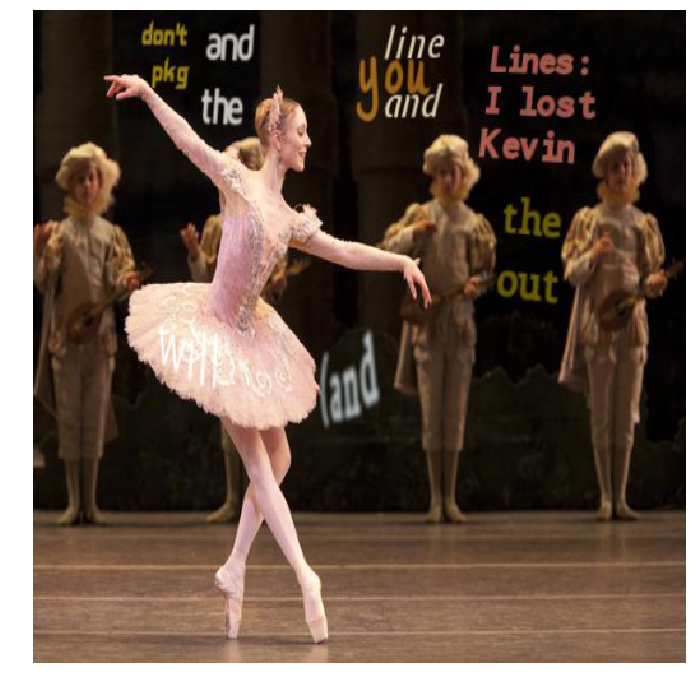

1/1 [==============================] - 2s 2s/step


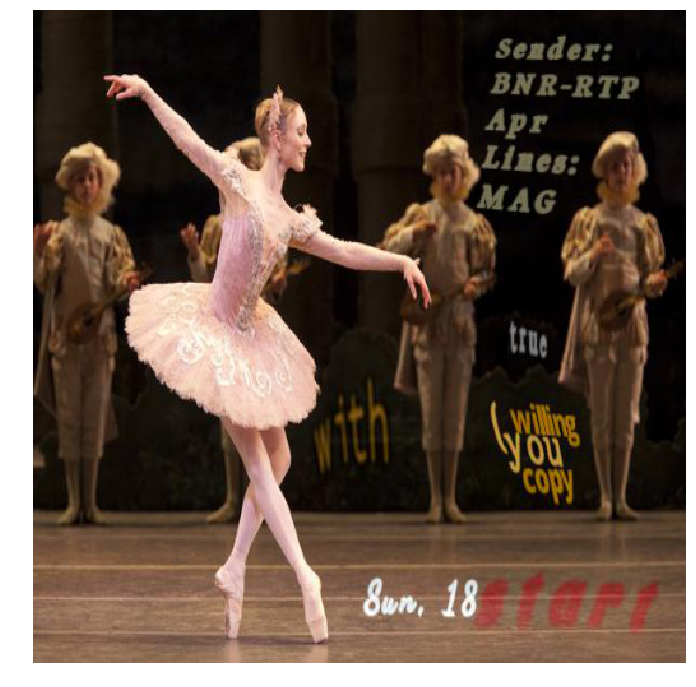

1/1 [==============================] - 3s 3s/step


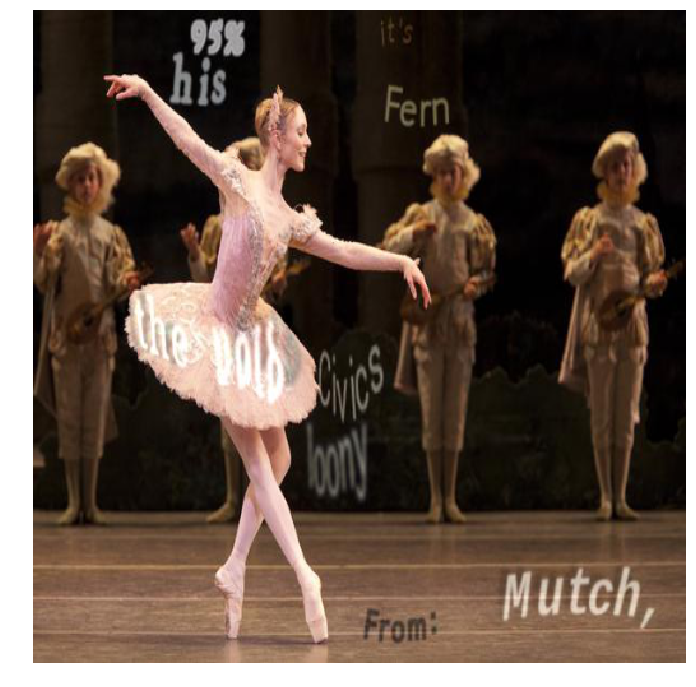

1/1 [==============================] - 2s 2s/step


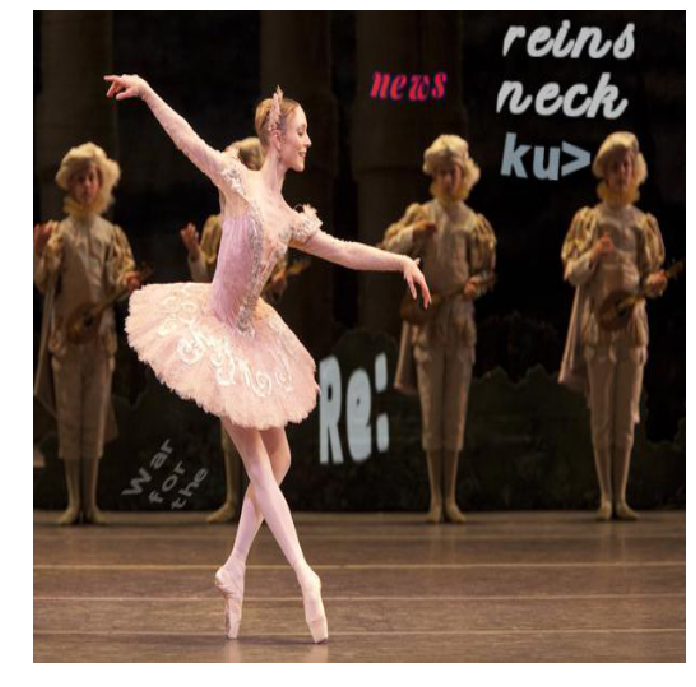

1/1 [==============================] - 3s 3s/step


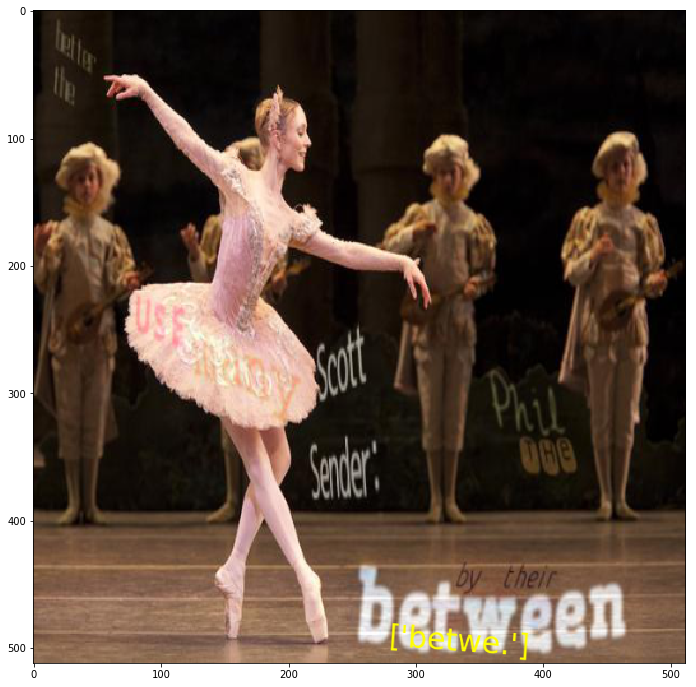

++++++++++++ BEFORE +++++++++++++
GT: ['scott', 'sender:', 'use', 'between', 'the', 'better', 'the', 'many', 'by', 'their', 'phil']
PR: ['betwe.']
RW: ['betwe.']

++++++++++++ AFTER +++++++++++++
GT: ['scott', 'sender:', 'use', 'between', 'the', 'better', 'the', 'many', 'by', 'their', 'phil']
PR: ['betwe.']
RW: []

++++++++++++++++++++++++++++++++
TP: 0
FP: 1
FN: 11
PRECISION: 0.0
RECALL: 0.0
FSCORE: 0
ACCURACY: 0.0


1/1 [==============================] - 2s 2s/step


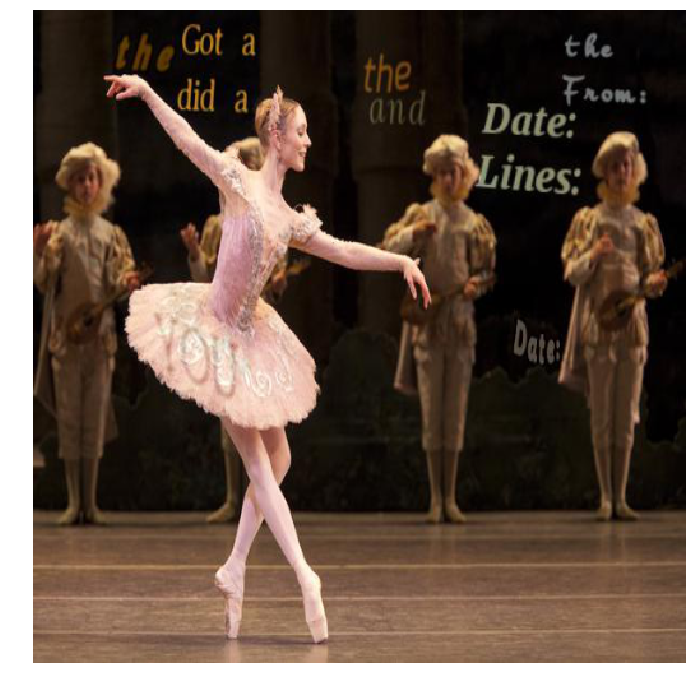

1/1 [==============================] - 3s 3s/step


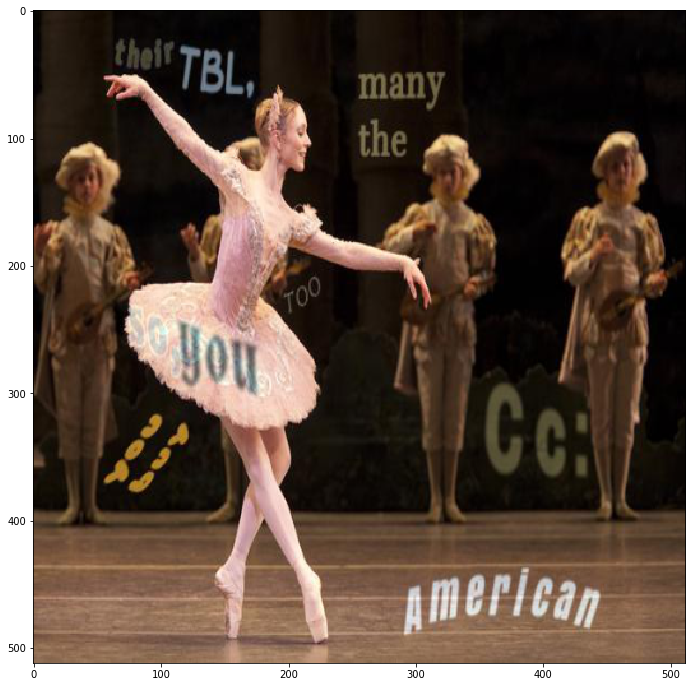

++++++++++++ BEFORE +++++++++++++
GT: ['you', 'american', 'too', 'many', 'the', 'tbl,', 'cc:', 'so,', 'you', 'buy', 'their']
PR: []
RW: []

++++++++++++ AFTER +++++++++++++
GT: ['you', 'american', 'too', 'many', 'the', 'tbl,', 'cc:', 'so,', 'you', 'buy', 'their']
PR: []
RW: []

++++++++++++++++++++++++++++++++
TP: 0
FP: 0
FN: 11
PRECISION: 0
RECALL: 0.0
FSCORE: 0
ACCURACY: 0.0


1/1 [==============================] - 3s 3s/step


KeyboardInterrupt: 

In [17]:
from CRNN.crnn_data import crop_words
from CRNN.crnn_utils import decode
from SegLink.sl_utils import rbox_to_polygon, polygon_to_rbox
from SegLink.ssd_viz import plot_box, escape_latex

import matplotlib.patches as patches
from skimage.transform import resize as rs

def visualize_bounding_box(image, labels):
    fig, ax = plt.subplots(1)
    ax.imshow(image)
    for b in labels.tolist():
        points = [[float(b[0]), float(b[1])], [float(b[2]), float(b[3])], [float(b[4]), float(b[5])], [float(b[6]), float(b[7])]]
        bb = patches.Polygon(points, alpha=0.3, linewidth=2, edgecolor='r', facecolor='b')
        ax.add_patch(bb)
    plt.show()
    
# boxes = np.copy(gtu.data[k][:,:-gtu.num_classes])
# texts = np.copy(gtu.text[k])    
# words = crop_words(img, boxes, input_height, width=input_width, grayscale=True)
# words = np.asarray([w.transpose(1,0,2) for w in words])

# gts = glob.glob("./data/icdar_2013_focused_scene_text/localization/testing/gt/*.txt")
inputs = []
images = []
images_orig = []
data = []
counter = 0
gtu = gt_util_synth
total_correct = 0
total_imgs = 0
total_text = 0
total_time = 0
total_accuracy = 0

total_p = 0
total_r = 0
total_f = 0

total_tp = 0
total_tn = 0
total_fp = 0
total_fn = 0
for i in range(0, gtu.num_samples):
    img = cv2.imread(os.path.join(gtu.image_path, gtu.image_names[i]))
    images_orig.append(np.copy(img)) 
    start = time.time()
    preds = model.predict(np.asarray([preprocess(img, image_size)]), batch_size=1, verbose=1)
    h, w = image_size
    img = cv2.resize(img, (w,h), cv2.INTER_LINEAR).astype('float32')
    img = img[:, :, (2,1,0)]
    img /= 255
    images.append(img)
    plt.figure(figsize=[12]*2)
    plt.imshow(images[i])
    boxes = gtu.data[i]
    data.append(boxes)
    img2 = img.copy()
    
    texts = np.copy(gtu.text[i]).tolist()
    res = prior_util.decode(preds[0], segment_threshold=0.4, link_threshold=0.2)
    img = images_orig[-1]
    rboxes = res[:,:5]
#     if len(rboxes) == 0:
#         continue
    if len(rboxes) == 0:
        plt.axis('off')
        plt.show()
        continue
        
    # ADD A SMALL PADDING TO THE DETECTED BOXES BEFORE RECOGNITION
    bh = rboxes[:,3]
    rboxes[:,2] += bh * 0.1
    rboxes[:,3] += bh * 0.2
    
    boxes = np.asarray([rbox_to_polygon(r) for r in rboxes])
    boxes = np.flip(boxes, axis=1)
    boxes = np.reshape(boxes, (-1, 8))

    boxes_mask_a = np.array([b[2] > b[3] for b in rboxes]) # width > height, in square world
    boxes_mask_b = np.array([not (np.any(b < 0) or np.any(b > 512)) for b in boxes]) # box inside image
    boxes_mask = np.logical_and(boxes_mask_a, boxes_mask_b)

    boxes = boxes[boxes_mask]
    rboxes = rboxes[boxes_mask]

    if len(boxes) == 0:
        boxes = np.empty((0,8))
                
    for box in boxes:
        for j in range(len(box)):
            if j % 2 == 0:
                box[j] = box[j]/512
            else:
                box[j] = box[j]/512
    words = crop_words(img, boxes, input_height, width=input_width, grayscale=True)
    words = np.asarray([w.transpose(1,0,2) for w in words])

    if len(words) > 0:
        res_crnn = crnn_model.predict(words)
    else:
        res_crnn = []
    segmented_words = []
    raw_preds = []
    for k in range(len(res_crnn)):
        chars = [alphabet[c] for c in np.argmax(res_crnn[k], axis=1)]        
        res_str = decode(chars)
        x, y, w, h, theta = rboxes[k]
        new_string = escape_latex(res_str).lower().strip()
#         segmented_words.append(new_string)
#         raw_preds.append(new_string)
        new_string = new_string.split(' ')
        segmented_word = []
        for t in new_string:
            raw_preds.append(t)
            for q in LM.segment.segment(t):
                segmented_word.append(q)
        for word in segmented_word:
            word = LM.clean.correction(word)
            segmented_words.append(word)
            
        plt.text(x+h*np.sin(theta)/2, y+h*np.cos(theta)/2, new_string, rotation=theta/np.pi*180, 
                 horizontalalignment='center', color='yellow', fontsize=30)
           
    plt.show()
#     segmented_words2 = []
#     for k in range(len(res_crnn)):
#         chars = [alphabet[c] for c in np.argmax(res_crnn[k], axis=1)]        
#         res_str = decode(chars)
#         x, y, w, h, theta = rboxes[k]
#         new_string = escape_latex(res_str).lower()
#         segmented_words2.append(new_string)
        
#     segmented_words3 = []
#     for k in range(len(res_crnn)):
#         chars = [alphabet[c] for c in np.argmax(res_crnn[k], axis=1)]        
#         res_str = decode(chars)
#         x, y, w, h, theta = rboxes[k]
#         new_string = escape_latex(res_str).lower()
#         segmented_word = segment.segment(new_string)
#         for word in segmented_word:
#             segmented_words3.append(word)
    
    end = time.time()
    took = end-start
#     print("Took:", took)
    total_time+=took
    for j in range(len(texts)):
        texts[j] = texts[j].lower().strip()
    segmented_words = raw_preds    
    
    dummy_texts = texts.copy()
    dummy_segmented_words = segmented_words.copy()
    num_correct = 0
    tp = 0; tn = 0; fp = 0; fn = 0
    print("++++++++++++ BEFORE +++++++++++++")
    print("GT:", texts)
    print("PR:", segmented_words)
    print("RW:", raw_preds)
    
    for a in range(len(segmented_words)):
        pred_word = segmented_words[a]
        if pred_word in dummy_texts:
            dummy_texts.remove(pred_word)
            dummy_segmented_words.remove(pred_word)
            num_correct+=1
            tp+=1
    print("\n++++++++++++ AFTER +++++++++++++")   
    fn = len(dummy_texts)
    fp = len(dummy_segmented_words)
    print("GT:", dummy_texts)
    print("PR:", dummy_segmented_words)
    print("RW:", [item for item in raw_preds if item not in segmented_words])
#     print("RW:", raw_preds)   
    print("\n++++++++++++++++++++++++++++++++")
    print("TP:", tp)
    print("FP:", fp)
    print("FN:", fn)
    total_tp+=tp
    total_fp+=fp
    total_fn+=fn
    
    p = precision(tp, fp)
    r = recall(tp, fn)
    f = fscore(p, r)
    print("PRECISION:", p)
    print("RECALL:", r)
    print("FSCORE:", f)
    
    total_p+=p
    total_r+=r
    total_f+=f
            
    acc = num_correct/len(texts)
    print("ACCURACY:", acc)
    total_correct+=num_correct
    total_imgs+=1
    total_text+=len(texts)
    total_accuracy+=acc
    print("\n=============================================================================\n")
print("Total Correct:", total_correct)
print("Total Images:", total_imgs)
print("Total Text:", total_text)
print("Total Time:", total_time)
print("Total Accuracy:", total_accuracy)
print("Total Precision:", total_p)
print("Total Recall:", total_r)
print("Total Fscore:", total_f)

In [ ]:
# print(total_correct/total_text)
# print(total_imgs/total_time)
# print(total_accuracy/total_imgs)
# print("\n")
# print("P:", total_p/total_imgs)
# print("R:", total_r/total_imgs)
# print("F:", fscore(total_p/total_imgs, total_r/total_imgs))
# print("F:", total_f/total_imgs)
# print("\n")
# print(total_tp)
# print(total_fp)
# print(total_fn)
# print("\n")
# print("P:", precision(total_tp, total_fp))
# print("R:", recall(total_tp, total_fn))
# print("F:", fscore(precision(total_tp, total_fp), recall(total_tp, total_fn)))

In [ ]:
# from crnn_data import crop_words
# from crnn_utils import decode
# from sl_utils import rbox_to_polygon, polygon_to_rbox
# from ssd_viz import plot_box, escape_latex

# gtu = gt_util_synth
# correct = 0
# total = 0
# total_time = 0
# for k in range(0, gtu.num_samples, 16):
# #     boxes = gtu.data[k][:,-8:]
# #     print(boxes.shape)
    
#     img_path = os.path.join(gtu.image_path, gtu.image_names[k])
#     img = cv2.imread(img_path)
    
# #     boxes = np.copy(gtu.data[k][:,:-2])
# #     print(boxes)
# #     texts = np.copy(gtu.text[k])

# #     mask = np.array([not (np.any(b < 0.) or np.any(b > 1.)) for b in boxes])
# #     boxes = boxes[mask]
# #     texts = texts[mask]

# #     if len(boxes) == 0: continue

# #     try:
# #         words = crop_words(img, boxes, input_height, width=input_width, grayscale=True)
# #     except Exception as e:
# #         import traceback
# #         print(traceback.format_exc())
# #         print(img_path)
# #         continue

# #     # drop words with width > height here
# #     mask = np.array([w.shape[1] > w.shape[0] for w in words])
# #     words = np.asarray(words)[mask]
# #     texts = texts[mask]

# #     for box in boxes:
# #         for i in range(len(box)):
# #             if i % 2 == 0:
# #                 box[i] = box[i]/512
# #             else:
# #                 box[i] = box[i]/512
# #     words = crop_words(img, boxes, input_height, width=input_width, grayscale=True)
# #     words = np.asarray([w.transpose(1,0,2) for w in words])
    
#     boxes = np.copy(gtu.data[k][:,:-gtu.num_classes])
#     texts = np.copy(gtu.text[k])    
#     words = crop_words(img, boxes, input_height, width=input_width, grayscale=True)
#     words = np.asarray([w.transpose(1,0,2) for w in words])
#     start = time.time()
#     if len(words) > 0:
#         res_crnn = crnn_model.predict(words)
#     else:
#         res_crnn = []
    
#     total+=len(texts)
#     for i in range(len(res_crnn)):
#         chars = [alphabet[c] for c in np.argmax(res_crnn[i], axis=1)]       
#         res_str = decode(chars)
# #         print(escape_latex(res_str), texts[i])
#         if escape_latex(res_str).lower() == texts[i].lower():
#             correct+=1
# #     print("=============================================================================")
#     end = time.time()
#     total_time+=(end-start)
#     print("Took:", (end-start))
# print(total_time)

In [ ]:
# num_imgs = 0
# for k in range(0, gtu.num_samples, 16):
#     num_imgs+=1
# print(correct/total)
# print(num_imgs/total_time)

## Video End to end - no tracking

In [ ]:
# def load_video(rootpath, filetype):
#     vids = []
#     fnames = []
#     for filename in glob.glob(rootpath + "*." + filetype):
#         actual_filename = filename.split("/")[-1]
#         fnames.append(actual_filename.split(".")[0])
#         vids.append(imageio.get_reader(filename,  'ffmpeg'))
#     fnames, vids = zip(*sorted(zip(fnames, vids)))
#     return fnames, vids

# def load_video_gt():
#     paths = glob.glob("./data/fixed_video_gt/Fixed_*.txt")
#     paths.sort()
#     gt = []
#     for path in paths:
#         with open(path) as f:
#             content = f.read().splitlines()
#         video_gt = []
#         frame_gt = []
#         for i in range(len(content)):
#             if content[i] == "FRAME":
#                 video_gt.append(frame_gt)
#                 frame_gt = []
#             else:
#                 lbl = content[i].split()
#                 lbl = lbl[0].split(",")
#                 for i in range(8):
#                     lbl[i] = float(lbl[i])
#                 frame_gt.append(lbl)
#         gt.append(video_gt)
#     return gt

# def remove_values_from_list(the_list, val):
#     return [value for value in the_list if value != val]

# def load_testfourgt():
#     with open('./data/testfourgt.txt') as f:
#         content = f.read().splitlines()
#     gt = []
#     for i in range(len(content)):
#         gttexts = content[i].split(' ')
#         for j in range(len(gttexts)):
#             gttexts[j] = gttexts[j].lower()
#         gt.append(remove_values_from_list(gttexts, ''))
# #         if gttexts[j] != '':
# #             gt.append(gttexts)
# #         else:
# #             gt.append([])
#     return gt

# # video_names, videos = load_video("./data/icdar_2015_text_in_video/training/", "mp4")
# # gt = load_video_gt()
# testfourgt = load_testfourgt()

In [ ]:
print(testfourgt[-1])

In [ ]:
# def postprocess_detections(preds, segment_threshold=0.4, link_threshold=0.3):
#     res = prior_util.decode(preds[0], segment_threshold=segment_threshold, link_threshold=link_threshold, debug=False)
#     rboxes = res
#     if len(rboxes) == 0:
#         return []

#     bh = rboxes[:,3]
#     rboxes[:,2] += bh * 0.2
#     rboxes[:,3] += bh * 0.2

#     boxes = []
#     for r in rboxes:
#         ds = r[:5]
#         r2p = rbox_to_polygon(ds)
#         boxes.append(r2p)

#     boxes = np.asarray(boxes)
#     boxes = np.flip(boxes, axis=1) 
#     boxes = np.reshape(boxes, (-1, 8))

#     boxes_mask_a = np.array([b[2] > b[3] for b in rboxes]) 
#     boxes_mask_b = np.array([not (np.any(b < 0) or np.any(b > image_size[0])) for b in boxes]) 
#     boxes_mask = np.logical_and(boxes_mask_a, boxes_mask_b)

#     boxes = boxes[boxes_mask]
#     rboxes = rboxes[boxes_mask]
#     if len(boxes) == 0:
#         boxes = np.empty((0,8))
#     return boxes

# def recognize_detected_text(img, boxes):
#     words = crop_words(img, boxes/image_size[0], input_height, width=input_width, grayscale=True)
#     words = np.asarray([w.transpose(1,0,2) for w in words])
#     if len(words) > 0:
#         res_crnn = crnn_model.predict(words)
#     else:
#         res_crnn = []   
        
#     segmented_words = []
#     raw_preds = []
#     for k in range(len(res_crnn)):
#         chars = [alphabet[c] for c in np.argmax(res_crnn[k], axis=1)]        
#         res_str = decode(chars)
#         new_string = escape_latex(res_str).lower().strip()
#         new_string = new_string.split(' ')
#         segmented_word = []
#         for t in new_string:
# #             raw_preds.append(t)
# #             segmented_word.append(t)
#             for q in segment.segment(t):
#                 segmented_word.append(q)
#         for word in segmented_word:
#             word = clean.correction(word)
#             segmented_words.append(word)
#     return segmented_words
        
# def flatten(inp):
#     new_list = []
#     for i in inp:
#         for j in i:
#             new_list.append(j)
#     return new_list


# def show_video_with_preds(video_path, labels, show_text=False):
#     camera = cv2.VideoCapture(video_path)
#     total_frame_count = int(camera.get(cv2.CAP_PROP_FRAME_COUNT))
#     _, frame = camera.read()
#     fps = camera.get(cv2.CAP_PROP_FPS)
#     counter = 0
#     total_correct = 0
#     total_imgs = 0
#     total_text = 0
#     total_time = 0
#     total_accuracy = 0

#     total_p = 0
#     total_r = 0
#     total_f = 0

#     total_tp = 0
#     total_tn = 0
#     total_fp = 0
#     total_fn = 0
#     start = time.time()
#     while True:
#         (grabbed, frame) = camera.read()
#         if not grabbed:
#             break
#         frame = cv2.rotate(frame,rotateCode = 0)
#         current_color_frame = cv2.resize(frame, (image_size[1], image_size[1]))
#         inputs = np.asarray([preprocess(current_color_frame, image_size)])
#         preds = model.predict(inputs, batch_size=1, verbose=1)
#         boxes = postprocess_detections(preds, segment_threshold=0.6, link_threshold=0.20)
#         frame_preds = []
#         raw_preds = []
#         if len(boxes) > 0:
#             rw = recognize_detected_text(current_color_frame, boxes)
# #             frame_preds.append(sg)
#             raw_preds.append(rw)
# #             frame_preds = flatten(frame_preds)
#             frame_preds = flatten(raw_preds)
#         frame_gts = labels[counter]
# #         frame_gts = []
# #         for label in frame_labels:
# #             if label[-1] == "##DONT#CARE##":
# #                 continue 
# #             frame_gts.append(label[-1].lower())
        
#         num_correct = 0
#         tp = 0; tn = 0; fp = 0; fn = 0
#         dummy_texts = frame_gts.copy()
#         dummy_segmented_words = frame_preds.copy()
#         print("GT:", dummy_texts)
#         print("PR:", dummy_segmented_words)
# #         print("RW:", raw_preds)
#         for a in range(len(frame_preds)):
#             pred_word = frame_preds[a]
#             if pred_word in dummy_texts:
#                 dummy_texts.remove(pred_word)
#                 dummy_segmented_words.remove(pred_word)
#                 num_correct+=1
#                 tp+=1
#         print('\n')
#         print("GT:", dummy_texts)
#         print("PR:", dummy_segmented_words)
#         print("-"*100)
#         fn = len(dummy_texts)
#         fp = len(dummy_segmented_words)
#         print(tp, fp, fn)
#         total_tp+=tp
#         total_fp+=fp
#         total_fn+=fn
#         p = precision(tp, fp)
#         r = recall(tp, fn)
#         f = fscore(p, r)
#         total_p+=p
#         total_r+=r
#         total_f+=f
#         if len(frame_gts) == 0:
#             acc = 0
#         else:
#             acc = num_correct/len(frame_gts)
#         total_correct+=num_correct
#         total_imgs+=1
#         total_text+=len(frame_gts)
#         total_accuracy+=acc
    
#         counter += 1
#         cv2.imshow("Current Frame", current_color_frame)    
#         cv2.waitKey(1)
        
#     camera.release()
#     cv2.destroyAllWindows()
#     end = time.time()
#     elapsed = end-start
#     print("Number of Frames:", total_frame_count)
#     print("Elapsed Time:", elapsed)
#     total_time+=elapsed
#     print("Average FPS:", total_frame_count / elapsed)
#     print(total_correct,
#             total_imgs,
#             total_text,
#             total_time,
#             total_accuracy,
#             total_p,
#             total_r,
#             total_f,
#             total_tp,
#             total_tn,
#             total_fp,
#             total_fn)
#     print(precision(total_tp, total_fp))
#     print(recall(total_tp, total_fn))
#     print(fscore(precision(total_tp, total_fp), recall(total_tp, total_fn)))
    
# # video_index = 17
# # video_path = "./data/icdar_2015_text_in_video/training/" + video_names[video_index] + ".mp4"
# video_path = "./data/testfour.mov"
# # show_video_with_preds(video_path, gt[video_index], show_text=False)
# show_video_with_preds(video_path, testfourgt, show_text=False)

### Video end-to-end with tracking

In [ ]:
# lk_params = dict(winSize = (10, 10), 
#                  maxLevel = 8, 
#                  criteria = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 100, 0.1))

# def track_point(old_frame, new_frame, old_points):
#     new_points, status, error = cv2.calcOpticalFlowPyrLK(old_frame, new_frame, old_points, None, **lk_params)
#     return new_points, status

# def draw_bounding_box(frame, box, color):
#     vrx = np.array(box, np.int32)
#     vrx = vrx.reshape((-1,1,2))
#     frame = cv2.polylines(frame, [vrx], True, color, 2)
#     return frame

# def draw_text(frame, text, box):
#     avg_x = int(round((box[0] + box[2] + box[4] + box[6]) / 4))
#     half_width = int(round((max(box[0], box[2], box[4], box[6]) - min(box[0], box[2], box[4], box[6]))/2))
#     avg_y = int(round((box[1] + box[3] + box[5] + box[7]) / 4))
#     cv2.putText(frame, text, (avg_x-half_width, avg_y+30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,0,255), 2)
    
# # def postprocess_detections(preds, segment_threshold=0.4, link_threshold=0.3):
# #     res = prior_util.decode(preds[0], segment_threshold=segment_threshold, link_threshold=link_threshold, debug=False)
# #     rboxes = res
# #     if len(rboxes) == 0:
# #         return []

# #     bh = rboxes[:,3]
# #     rboxes[:,2] += bh * 0.2
# #     rboxes[:,3] += bh * 0.2

# #     boxes = []
# #     for r in rboxes:
# #         ds = r[:5]
# #         r2p = rbox_to_polygon(ds)
# #         boxes.append(r2p)

# #     boxes = np.asarray(boxes)
# #     boxes = np.flip(boxes, axis=1) 
# #     boxes = np.reshape(boxes, (-1, 8))

# #     boxes_mask_a = np.array([b[2] > b[3] for b in rboxes]) 
# #     boxes_mask_b = np.array([not (np.any(b < 0) or np.any(b > image_size[0])) for b in boxes]) 
# #     boxes_mask = np.logical_and(boxes_mask_a, boxes_mask_b)

# #     boxes = boxes[boxes_mask]
# #     rboxes = rboxes[boxes_mask]
# #     if len(boxes) == 0:
# #         boxes = np.empty((0,8))
# #     return boxes

# # def recognize_detected_text(img, boxes):
# #     words = crop_words(img, boxes/image_size[0], input_height, width=input_width, grayscale=True)
# #     words = np.asarray([w.transpose(1,0,2) for w in words])
# #     if len(words) > 0:
# #         res_crnn = crnn_model.predict(words)
# #     else:
# #         res_crnn = []        
# #     recognized_text = []
# #     for i in range(len(res_crnn)):
# #         chars = [alphabet[c] for c in np.argmax(res_crnn[i], axis=1)]
# #         res_str = decode(chars)
# #         recognized_text.append(res_str)
# #     return recognized_text

# def shift_box(initial_points, new_points, status, box):
#     delta_x = 0; delta_y = 0
#     delta_x_list = []; delta_y_list = []
#     for k in range(len(initial_points)):
#         if status[k] == 0:
#             continue
#         delta_x = delta_x - (initial_points[k][0][0] - new_points[k][0][0])
#         delta_y = delta_y - (initial_points[k][0][1] - new_points[k][0][1])
#         delta_x_list.append(delta_x)
#         delta_y_list.append(delta_y)
#     delta_x_list.sort()
#     delta_y_list.sort()
#     median_delta_x = statistics.median(delta_x_list)
#     median_delta_y = statistics.median(delta_y_list)
    
#     delta_x = 0; delta_y = 0
#     THRES = 1.1
#     for k in range(len(initial_points)):
#         if status[k] == 0:
#             continue
#         if (abs(initial_points[k][0][0] - new_points[k][0][0])) < (abs(THRES * median_delta_x)) and (abs(initial_points[k][0][1] - new_points[k][0][1])) < (abs(THRES * median_delta_y)):
#             delta_x = delta_x - (initial_points[k][0][0] - new_points[k][0][0])
#             delta_y = delta_y - (initial_points[k][0][1] - new_points[k][0][1])
#     mean_delta_x = delta_x / len(initial_points)
#     mean_delta_y = delta_y / len(initial_points)

#     shifted_box = [box[0] + mean_delta_x, 
#                    box[1] + mean_delta_y, 
#                    box[2] + mean_delta_x, 
#                    box[3] + mean_delta_y, 
#                    box[4] + mean_delta_x,
#                    box[5] + mean_delta_y,
#                    box[6] + mean_delta_x,
#                    box[7] + mean_delta_y]
    
#     broken = False
#     for i in range(len(shifted_box)):
#         if shifted_box[i] < 0:
#             broken = True
#         if (i%2 == 0) and (shifted_box[i] > image_size[1]):
#             broken = True
#         if (i%2 == 1) and (shifted_box[i] > image_size[0]):
#             broken = True
            
#     return shifted_box, broken

# def create_text_mask(frame, box):
#     mask = np.zeros(frame.shape, dtype=np.uint8)
#     roi_corners = np.array([[(box[0], box[1]), (box[2], box[3]), (box[4], box[5]), (box[6], box[7])]], dtype=np.int32)
#     channel_count = frame.shape[2]
#     ignore_mask_color = (255,)*channel_count
#     cv2.fillPoly(mask, roi_corners, ignore_mask_color)
#     masked_image = cv2.bitwise_and(frame, mask)
#     gray_masked_image = cv2.cvtColor(masked_image, cv2.COLOR_BGR2GRAY)
#     return gray_masked_image

# def create_padded_text_mask(frame, box, padding=10):
#     mask = np.zeros(frame.shape, dtype=np.uint8)
#     minX = min([box[0], box[2], box[4], box[6]]) - padding
#     maxX = max([box[0], box[2], box[4], box[6]]) + padding
#     minY = min([box[1], box[3], box[5], box[7]]) - padding
#     maxY = max([box[1], box[3], box[5], box[7]]) + padding
#     if minX < 0:
#         minX = 0
#     if maxX > image_size[1]:
#         maxX = image_size[1]
#     if minY < 0:
#         minY = 0
#     if maxY > image_size[0]:
#         maxY = image_size[0]
        
#     roi_corners = np.array([[(minX, minY), (maxX, minY), (maxX, maxY), (minX, maxY)]], dtype=np.int32)
#     channel_count = frame.shape[2]
#     ignore_mask_color = (255,)*channel_count
#     cv2.fillPoly(mask, roi_corners, ignore_mask_color)
#     masked_image = cv2.bitwise_and(frame, mask)
#     gray_masked_image = cv2.cvtColor(masked_image, cv2.COLOR_BGR2GRAY)
#     return gray_masked_image

# def generate_initial_tracking_points(frame, box):
#     gray_masked_image = create_text_mask(frame, box)
#     corners = cv2.goodFeaturesToTrack(gray_masked_image, 100, minDistance=1, qualityLevel=0.05)
#     corners = np.int0(corners)
#     if len(corners) < 10:
#         return np.array([[]], dtype=np.float32)
#     pnt_list = []
#     for corner in corners:
#         x, y = corner.ravel()
#         pnt = [x, y]
#         pnt_list.append(pnt)
#     initial_points = np.array(pnt_list, dtype=np.float32)
#     return initial_points.reshape((len(initial_points),1,2))

# def show_gt(frame, labels, counter, show_text=False):    
#     frame_labels = labels[counter]
#     for label in frame_labels:
#         if label[-1] == "##DONT#CARE##":
#             continue 
        
#         vrx = np.array(label[:8], np.int32)
#         vrx = vrx.reshape((-1,1,2))
#         frame = cv2.polylines(frame, [vrx], True, (0,255,255),2)
#         if show_text:
#             avg_x = int(round((label[0] + label[2] + label[4] + label[6]) / 4))
#             half_width = int(round((max(label[0], label[2], label[4], label[6]) - min(label[0], label[2], label[4], label[6]))/2))
#             avg_y = int(round((label[1] + label[3] + label[5] + label[7]) / 4))
#             cv2.putText(frame, label[-1], (avg_x-half_width, avg_y+30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,0,255), 2)

# def recognize_and_display(img, boxes, frame, show_text=False):
#     recognized_text = recognize_detected_text(img, boxes)
#     if show_text:
#         for i in range(len(recognized_text)):
#             draw_text(frame, recognized_text[i], boxes[i])

# def get_orb_features(frame, box, old_frame, new_frame):
#     orb = cv2.ORB_create()
#     old_mask = create_text_mask(frame, box)
#     new_mask = create_padded_text_mask(frame, box, padding=10)
    
#     kp1, des1 = orb.detectAndCompute(new_frame, new_mask)
#     kp2, des2 = orb.detectAndCompute(old_frame, old_mask)

#     bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
#     matches = bf.match(des1,des2)
#     if len(matches) < 10:
#         return [], []
#     matches = sorted(matches, key = lambda x:x.distance)
#     matches = matches[:10]
    
#     # what if the number of matches is too low or 0?

#     list_kp1 = []
#     list_kp2 = []
#     for mat in matches:
#         img1_idx = mat.queryIdx
#         img2_idx = mat.trainIdx
#         (x1,y1) = kp1[img1_idx].pt
#         (x2,y2) = kp2[img2_idx].pt
#         list_kp1.append([x1, y1])
#         list_kp2.append([x2, y2])
#     list_kp1 = np.array(list_kp1, dtype=np.float32)
#     list_kp2 = np.array(list_kp2, dtype=np.float32)
    
# #     for p in range(len(list_kp1)):
# #         point = list_kp1[p]
# #         point2 = list_kp2[p]
# #         cv2.circle(frame, (int(round(point[0])), int(round(point[1]))), 3, (255, 255, 0), -1) # cyan
# #         cv2.circle(frame, (int(round(point2[0])), int(round(point2[1]))), 3, (0, 255, 255), -1) #yellow

#     return list_kp1.reshape((len(list_kp1),1,2)), list_kp2.reshape((len(list_kp2),1,2))

# def track_quadrant(previous_color_frame, previous_gray_frame, current_color_frame, current_gray_frame, quadx, quady):
#     try:
#         img = previous_gray_frame[quady:quady+50, quadx:quadx+50]
#         corners = cv2.goodFeaturesToTrack(img, 100, minDistance=1, qualityLevel=0.05)
#         corners = np.int0(corners)
#         if len(corners) < 10:
#             return 999,999
#         pnt_list = []
#         for corner in corners:
#             x, y = corner.ravel()
#             pnt = [x, y]
#             pnt_list.append(pnt)
#         initial_points = np.array(pnt_list, dtype=np.float32)
#         initial_points = initial_points.reshape((len(initial_points),1,2))
#         if len(initial_points) == 0:
#             return 999,999
#         d_new_points, d_status, d_error = cv2.calcOpticalFlowPyrLK(previous_gray_frame, current_gray_frame, initial_points, None, **lk_params)

#         delta_x = 0; delta_y = 0
#         delta_x_list = []; delta_y_list = []
#         for k in range(len(initial_points)):
#             if d_status[k] == 0:
#                 continue
#             delta_x = delta_x - (initial_points[k][0][0] - d_new_points[k][0][0])
#             delta_y = delta_y - (initial_points[k][0][1] - d_new_points[k][0][1])
#             delta_x_list.append(delta_x)
#             delta_y_list.append(delta_y)
#         delta_x_list.sort()
#         delta_y_list.sort()
#         median_delta_x = statistics.median(delta_x_list)
#         median_delta_y = statistics.median(delta_y_list)

#         delta_x = 0; delta_y = 0
#         THRES = 1.1
#         for k in range(len(initial_points)):
#             if d_status[k] == 0:
#                 continue
#             if (abs(initial_points[k][0][0] - d_new_points[k][0][0])) < (abs(THRES * median_delta_x)) and (abs(initial_points[k][0][1] - d_new_points[k][0][1])) < (abs(THRES * median_delta_y)):
#                 delta_x = delta_x - (initial_points[k][0][0] - d_new_points[k][0][0])
#                 delta_y = delta_y - (initial_points[k][0][1] - d_new_points[k][0][1])
#         mean_delta_x = delta_x / len(initial_points)
#         mean_delta_y = delta_y / len(initial_points)
#         return mean_delta_x, mean_delta_y
#     except:
#         return 999,999
        
# # def show_video_with_preds(video_path, labels, show_text=False):
# #     camera = cv2.VideoCapture(video_path)
# #     total_frame_count = int(camera.get(cv2.CAP_PROP_FRAME_COUNT))
# #     old_points = np.array([[]])
# #     _, frame = camera.read()
# #     old_color_frame = cv2.resize(frame, (image_size[1], image_size[0]))
# #     old_gray_frame = cv2.cvtColor(old_color_frame, cv2.COLOR_BGR2GRAY)
# #     fps = camera.get(cv2.CAP_PROP_FPS)
# #     COUNTER = 1
# #     LAST_FRAME_NUMBER_WITH_DETECTION = -4
# #     NUMBER_OF_FRAMES_SINCE_LAST_DETECTION = 0
# #     old_boxes = []
# #     totalX = 0; totalY = 0
    
# #     while True:
# #         (grabbed, frame) = camera.read()
# #         if not grabbed:
# #             break
        
# #         current_color_frame = cv2.resize(frame, (image_size[1], image_size[1]))
# #         current_color_frame_copy = current_color_frame.copy()
# #         current_gray_frame = cv2.cvtColor(current_color_frame, cv2.COLOR_BGR2GRAY)
# #         NUMBER_OF_FRAMES_SINCE_LAST_DETECTION = COUNTER - LAST_FRAME_NUMBER_WITH_DETECTION
        
# #         start = time.time()
# # #         a = cv2.resize(old_gray_frame, (150, 150))
# # #         b = cv2.resize(current_gray_frame, (150, 150))
# # #         c = cv2.resize(old_color_frame, (150, 150))
# # #         d = cv2.resize(current_color_frame, (150, 150))
        
# # #         x1, y1 = track_quadrant(c, a, d, b, 0, 0)
# # #         x2, y2 = track_quadrant(c, a, d, b, 50, 0)
# # #         x3, y3 = track_quadrant(c, a, d, b, 100, 0)
# # #         x4, y4 = track_quadrant(c, a, d, b, 0, 50)
# # #         x5, y5 = track_quadrant(c, a, d, b, 50, 50)
# # #         x6, y6 = track_quadrant(c, a, d, b, 100, 50)
# # #         x7, y7 = track_quadrant(c, a, d, b, 0, 100)
# # #         x8, y8 = track_quadrant(c, a, d, b, 50, 100)
# # #         x9, y9 = track_quadrant(c, a, d, b, 100, 100)
        
# # #         print(x1,y1)
# # #         print(x2,y2)
# # #         print(x3,y3)
# # #         print(x4,y4)
# # #         print(x5,y5)
# # #         print(x6,y6)
# # #         print(x7,y7)
# # #         print(x8,y8)
# # #         print(x9,y9)
        
# # #         if x1 + x2 + x3 + x4 + x5 + x6 + x7 + x8 + x9 < 600 and y1 + y2 + y3 + y4 + y5 + y6 + y7 + y8 + y9 < 600:
# # #             threshold = 10
# # #             strong_right = False; strong_left = False; strong_down = False; strong_up = False
# # #             weak_right = False; weak_left = False; weak_down = False; weak_up = False
# # #             if x1 > 0 and x2 > 0 and x3 > 0 and x4 > 0 and x5 > 0 and x6 > 0 and x7 > 0 and x8 > 0 and x9:
# # #                 avgX = (x1 + x2 + x3 + x4 + x5 + x6 + x7 + x8 + x9) / 9
# # #                 if avgX > threshold:
# # #                     strong_right = True
# # #                 else:
# # #                     weak_right = True

# # #             elif x1 < 0 and x2 < 0 and x3 < 0 and x4 < 0 and x5 < 0 and x6 < 0 and x7 < 0 and x8 < 0 and x9:
# # #                 avgX = (x1 + x2 + x3 + x4 + x5 + x6 + x7 + x8 + x9) / 9
# # #                 if avgX > -threshold:
# # #                     strong_left = True
# # #                 else:
# # #                     weak_left = True

# # #             if y1 > 0 and y2 > 0 and y3 > 0 and y4 > 0 and y5 > 0 and y6 > 0 and y7 > 0 and y8 > 0 and y9:
# # #                 avgY = (y1 + y2 + y3 + y4 + y5 + y6 + y7 + y8 + y9) / 9
# # #                 if avgY > threshold:
# # #                     strong_down = True
# # #                 else:
# # #                     weak_down = True

# # #             elif y1 < 0 and y2 < 0 and y3 < 0 and y4 < 0 and y5 < 0 and y6 < 0 and y7 < 0 and y8 < 0 and y9:
# # #                 avgY = (y1 + y2 + y3 + y4 + y5 + y6 + y7 + y8 + y9) / 9
# # #                 if avgY > -threshold:
# # #                     strong_up = True
# # #                 else:
# # #                     weak_up = True

# # #             if strong_right and weak_down and weak_up:
# # #                 print("RIGHT")
# # #                 ratio = avgX / 150
# # #                 ratio = ratio * 512
# # #                 section = int(128 * round(float(ratio)/128))
# # #                 cropped_image = current_color_frame[0:512, section:512]
# # #             elif strong_left and weak_down and weak_up:
# # #                 print("LEFT")
# # #                 ratio = avgX / 150
# # #                 ratio = ratio * 512
# # #                 section = int(128 * round(float(ratio)/128))
# # #                 cropped_image = current_color_frame[0:512, 0:512-section]
# # #             elif strong_down and weak_left and weak_right:
# # #                 print("DOWN")
# # #                 ratio = avgY / 150
# # #                 ratio = ratio * 512
# # #                 section = int(128 * round(float(ratio)/128))
# # #                 cropped_image = current_color_frame[section:512, 0:512]
# # #             elif strong_up and weak_left and weak_right:
# # #                 print("UP")
# # #                 ratio = avgY / 150
# # #                 ratio = ratio * 512
# # #                 section = int(128 * round(float(ratio)/128))
# # #                 cropped_image = current_color_frame[0:512-section, 0:512]
            
        
# # #         print("took:", time.time()-start)
        
# #         if NUMBER_OF_FRAMES_SINCE_LAST_DETECTION > 3:
# #             inputs = np.asarray([preprocess(current_color_frame, image_size)])
# #             preds = model.predict(inputs, batch_size=1, verbose=1)
# #             boxes = postprocess_detections(preds, segment_threshold=0.6, link_threshold=0.2)
# #             if len(boxes) > 0:
# #                 LAST_FRAME_NUMBER_WITH_DETECTION = COUNTER
# #                 for box in boxes:
# #                     current_color_frame = draw_bounding_box(current_color_frame, box, (0,0,255))
# #                     current_color_frame_copy = draw_bounding_box(current_color_frame_copy, box, (255,0,255))
# #                 old_boxes = boxes
# #                 recognize_and_display(img, boxes, current_color_frame, show_text=show_text)
    
# #         else:                    
# #             if len(old_boxes) > 0:
# #                 all_boxes = []
# #                 for box in old_boxes:
# #                     try:
# #                         initial_points = generate_initial_tracking_points(old_color_frame, box)
# #                         if len(initial_points) == 0:
# #                             continue
# #                         for pt in initial_points:
# #                             cv2.circle(old_color_frame,(pt[0][0], pt[0][1]), 3, (255,255,0), -1)
# #                         new_points, status = track_point(old_gray_frame, current_gray_frame, initial_points)
# #                         for i in range(len(new_points)):
# #                             if status[i] == 1:
# #                                 cv2.circle(current_color_frame,(new_points[i][0][0], new_points[i][0][1]), 3, (0,255,255), -1)
# #                         shifted_box, broken = shift_box(initial_points, new_points, status, box)
# #                         if broken:
# #                             continue
# #                         current_color_frame = draw_bounding_box(current_color_frame, shifted_box, (0,255,0))
# #                         all_boxes.append(shifted_box)
# #                         old_boxes = np.array(all_boxes)
# #                         recognize_and_display(img, boxes, current_color_frame, show_text=show_text)
# #                     except:
# #                         LAST_FRAME_NUMBER_WITH_DETECTION = COUNTER -5
# #                         break
        
# # #         cv2.imshow("Current Frame", current_color_frame)
# # #         cv2.imshow("Previous Frame", old_color_frame)
# #         old_color_frame = current_color_frame_copy.copy()
# #         old_gray_frame = current_gray_frame.copy()
# #         cv2.waitKey(10)
# #         COUNTER += 1
        
# #     camera.release()
# #     cv2.waitKey(0)
# #     cv2.destroyAllWindows()
# #     cv2.waitKey(1)


# def postprocess_detections(preds, segment_threshold=0.4, link_threshold=0.3):
#     res = prior_util.decode(preds[0], segment_threshold=segment_threshold, link_threshold=link_threshold, debug=False)
#     rboxes = res
#     if len(rboxes) == 0:
#         return []

#     bh = rboxes[:,3]
#     rboxes[:,2] += bh * 0.2
#     rboxes[:,3] += bh * 0.2

#     boxes = []
#     for r in rboxes:
#         ds = r[:5]
#         r2p = rbox_to_polygon(ds)
#         boxes.append(r2p)

#     boxes = np.asarray(boxes)
#     boxes = np.flip(boxes, axis=1) 
#     boxes = np.reshape(boxes, (-1, 8))

#     boxes_mask_a = np.array([b[2] > b[3] for b in rboxes]) 
#     boxes_mask_b = np.array([not (np.any(b < 0) or np.any(b > image_size[0])) for b in boxes]) 
#     boxes_mask = np.logical_and(boxes_mask_a, boxes_mask_b)

#     boxes = boxes[boxes_mask]
#     rboxes = rboxes[boxes_mask]
#     if len(boxes) == 0:
#         boxes = np.empty((0,8))
#     return boxes

# def recognize_detected_text(img, boxes):
#     words = crop_words(img, boxes/image_size[0], input_height, width=input_width, grayscale=True)
#     words = np.asarray([w.transpose(1,0,2) for w in words])
#     if len(words) > 0:
#         res_crnn = crnn_model.predict(words)
#     else:
#         res_crnn = []   
        
#     segmented_words = []
#     raw_preds = []
#     for k in range(len(res_crnn)):
#         chars = [alphabet[c] for c in np.argmax(res_crnn[k], axis=1)]        
#         res_str = decode(chars)
#         new_string = escape_latex(res_str).lower().strip()
#         new_string = new_string.split(' ')
#         segmented_word = []
#         for t in new_string:
# #             raw_preds.append(t)
# #             segmented_word.append(t)
#             for q in segment.segment(t):
#                 segmented_word.append(q)
#         for word in segmented_word:
#             word = clean.correction(word)
#             segmented_words.append(word)
#     return segmented_words
        
# def flatten(inp):
#     new_list = []
#     for i in inp:
#         for j in i:
#             new_list.append(j)
#     return new_list


# def show_video_with_preds(video_path, labels, show_text=False):   
#     camera = cv2.VideoCapture(video_path)
#     total_frame_count = int(camera.get(cv2.CAP_PROP_FRAME_COUNT))
#     _, frame = camera.read()
#     fps = camera.get(cv2.CAP_PROP_FPS)
#     old_points = np.array([[]])
#     old_color_frame = cv2.resize(frame, (image_size[1], image_size[0]))
#     old_gray_frame = cv2.cvtColor(old_color_frame, cv2.COLOR_BGR2GRAY)
#     COUNTER = 1
#     LAST_FRAME_NUMBER_WITH_DETECTION = -4
#     NUMBER_OF_FRAMES_SINCE_LAST_DETECTION = 0
#     old_boxes = []
#     totalX = 0; totalY = 0
    
#     counter = 0
#     total_correct = 0
#     total_imgs = 0
#     total_text = 0
#     total_time = 0
#     total_accuracy = 0

#     total_p = 0
#     total_r = 0
#     total_f = 0

#     total_tp = 0
#     total_tn = 0
#     total_fp = 0
#     total_fn = 0
#     start = time.time()
#     while True:
#         (grabbed, frame) = camera.read()
#         if not grabbed:
#             break
#         frame = cv2.rotate(frame,rotateCode = 0)
#         current_color_frame = cv2.resize(frame, (image_size[1], image_size[1]))
#         current_color_frame_copy = current_color_frame.copy()
#         current_gray_frame = cv2.cvtColor(current_color_frame, cv2.COLOR_BGR2GRAY)
#         NUMBER_OF_FRAMES_SINCE_LAST_DETECTION = COUNTER - LAST_FRAME_NUMBER_WITH_DETECTION
           
#         frame_gts = labels[counter]
#         frame_preds = []
#         if NUMBER_OF_FRAMES_SINCE_LAST_DETECTION > 3:
# #             print("IF")
#             inputs = np.asarray([preprocess(current_color_frame, image_size)])
#             preds = model.predict(inputs, batch_size=1, verbose=1)
#             boxes = postprocess_detections(preds, segment_threshold=0.6, link_threshold=0.2)
#             if len(boxes) > 0:
#                 print(len(boxes))
#                 LAST_FRAME_NUMBER_WITH_DETECTION = COUNTER
#                 old_boxes = boxes
#                 frame_preds.append(recognize_detected_text(current_color_frame, boxes))
    
#         else:          
# #             print("ELSE")
#             if len(old_boxes) > 0:
#                 all_boxes = []
#                 for box in old_boxes:
#                     try:
#                         initial_points = generate_initial_tracking_points(old_color_frame, box)
#                         if len(initial_points) == 0:
#                             continue
#                         new_points, status = track_point(old_gray_frame, current_gray_frame, initial_points)
#                         shifted_box, broken = shift_box(initial_points, new_points, status, box)
#                         if broken:
#                             continue
#                         all_boxes.append(shifted_box)
#                         old_boxes = np.array(all_boxes)
                        
                        
#                         #
#                         # Currently, we are making predictions on 'boxes' which is all the boxes.
#                         # However, these are from the detection, essentially giving us the same thing 4 times in a row.
#                         #
#                         # Instead we want to make a single recognition for each of the shifted boxes.
#                         # This should eliminate the duplication problem. But make sure that we are only making detections
#                         # every 4th time.
#                         #
#                         #
# #                         print('###############################################################')
# #                         print('boxes:', boxes)
# #                         print('\n')
# #                         jsb = np.array([shifted_box])
# #                         print(jsb)
# #                         print('shifted_box:', jsb)
# #                         print('###############################################################')
#                         frame_preds.append(recognize_detected_text(current_color_frame, np.array([shifted_box])))
#                     except:
#                         print("TRACKING ERROR")
#                         LAST_FRAME_NUMBER_WITH_DETECTION = COUNTER -5
#                         break
        
#         frame_preds = flatten(frame_preds)
# #         print("GT:", frame_gts)
# #         print("RW:", frame_preds)
        
#         num_correct = 0
#         tp = 0; tn = 0; fp = 0; fn = 0
#         dummy_texts = frame_gts.copy()
#         dummy_segmented_words = frame_preds.copy()
#         print("GT:", dummy_texts)
#         print("RW:", dummy_segmented_words)
#         for a in range(len(frame_preds)):
#             pred_word = frame_preds[a]
#             if pred_word in dummy_texts:
#                 dummy_texts.remove(pred_word)
#                 dummy_segmented_words.remove(pred_word)
#                 num_correct+=1
#                 tp+=1
#         print('\n')
#         print("GT:", dummy_texts)
#         print("RW:", dummy_segmented_words)
#         print("-"*100)
#         fn = len(dummy_texts)
#         fp = len(dummy_segmented_words)
#         print(tp, fp, fn)
#         total_tp+=tp
#         total_fp+=fp
#         total_fn+=fn
#         p = precision(tp, fp)
#         r = recall(tp, fn)
#         f = fscore(p, r)
#         total_p+=p
#         total_r+=r
#         total_f+=f
#         if len(frame_gts) == 0:
#             acc = 0
#         else:
#             acc = num_correct/len(frame_gts)
#         total_correct+=num_correct
#         total_imgs+=1
#         total_text+=len(frame_gts)
#         total_accuracy+=acc
    
#         counter += 1
#         cv2.imshow("Current Frame", current_color_frame)   
#         old_color_frame = current_color_frame_copy.copy()
#         old_gray_frame = current_gray_frame.copy()
#         cv2.waitKey(1)
#         COUNTER += 1
        
#     camera.release()
#     cv2.destroyAllWindows()
#     end = time.time()
#     elapsed = end-start
#     print("Number of Frames:", total_frame_count)
#     print("Elapsed Time:", elapsed)
#     total_time+=elapsed
#     print("Average FPS:", total_frame_count / elapsed)
#     print(total_correct,
#             total_imgs,
#             total_text,
#             total_time,
#             total_accuracy,
#             total_p,
#             total_r,
#             total_f,
#             total_tp,
#             total_tn,
#             total_fp,
#             total_fn)
#     print(precision(total_tp, total_fp))
#     print(recall(total_tp, total_fn))
#     print(fscore(precision(total_tp, total_fp), recall(total_tp, total_fn)))
    
# # video_index = 17
# # video_path = "./data/icdar_2015_text_in_video/training/" + video_names[video_index] + ".mp4"
# video_path = "./data/testfour.mov"
# # show_video_with_preds(video_path, gt[video_index], show_text=False)
# show_video_with_preds(video_path, testfourgt, show_text=False)